**Download dataset**

In [ ]:
!pip install -q gdown
!gdown --id 1ErivRe__3kjo9SlbmjSXEM7snEZ_M2zZ
!gdown --id 1VcSuMswEXUJz9R3XyHFTrw39ve1sWU8q
# !unzip -q Images.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ErivRe__3kjo9SlbmjSXEM7snEZ_M2zZ
From (redirected): https://drive.google.com/uc?id=1ErivRe__3kjo9SlbmjSXEM7snEZ_M2zZ&confirm=t&uuid=58b55a3b-811a-4bbd-ad3c-9081ef3f2190
To: /kaggle/working/Images.zip
100%|███████████████████████████████████████| 1.11G/1.11G [00:05<00:00, 219MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [2]:
import os
import pickle
import numpy as np
import pickle
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


2025-04-20 10:01:44.156178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745143304.390006      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745143304.453072      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Unzip data**

In [20]:
Imagezip = f"Images.zip"
Caption_path = f"captions.csv"

# img extracted will be at
ImageFolder = ''

In [7]:
# import zipfile


# with zipfile.ZipFile(Imagezip, 'r') as zip_ref:
#     zip_ref.extractall(ImageFolder)

In [8]:
ls

captions.csv  Images/  Images.zip


**Custom CNN model**

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

def create_custom_cnn(input_shape=(224, 224, 3)):
    model = Sequential()
    
    # Block 1
    model.add(Input(shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Fully connected layers (customizable for your use-case)
    model.add(Flatten())
        model.add(Dense(4096, activation='relu'))

    return model



In [18]:
custom_cnn = create_custom_cnn()

**Model Summary**

In [11]:
custom_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# # load vgg16 model
# model = VGG16()

# # restructure the model
# custom_cnn = Model(inputs=model.inputs, outputs=model.layers[-2].output)


I0000 00:00:1745143487.613640      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745143487.614275      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**extract features**

In [15]:
features = {}
directional = os.path.join(ImageFolder, 'Images')

for img_name in tqdm(os.listdir(directional)):
    img_path = directional + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = image / 255.0
    feature = custom_cnn.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8090 [00:00<?, ?it/s]

**Features saved to current directory**

In [16]:
# try:
#     pickle.dump(features, open(os.path.join(directional, 'features.pkl'), 'wb'))
#     print("dwdw")
# except Exception as e:
#     print(f"An error occurred: {e}")

try:
    with open('features.pkl', 'wb') as f:
        pickle.dump(features, f)
    print("Features saved to current directory as features.pkl")
except Exception as e:
    print(f"An error occurred: {e}")


Features saved to current directory as features.pkl


In [17]:
ls

captions.csv  features.pkl  Images/  Images.zip


In [44]:


# try:
#     with open('/features.pkl', 'wb') as f:
#         pickle.dump(features, f)
# except Exception as e:
#     print(f"An error occurred: {e}")



**Load features from pickle**

In [18]:
try:
    with open('features.pkl', 'rb') as f:
      features = pickle.load(f)
except Exception as e:
    print(f"An error occurred: {e}")


In [21]:
with open(Caption_path, 'r') as f:
    next(f)
    captions_doc = f.read()

In [22]:
# try:
#     with open('features.pkl', 'rb') as f:
#         features = pickle.load(f)
# except Exception as e:
#     print(f"An error occurred: {e}")



**Mapping of image to captions**

In [23]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
  tokens = line.split(',')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1]
  image_id = image_id.split('.')[0]
  caption = "".join(caption)
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)


  0%|          | 0/40451 [00:00<?, ?it/s]

In [24]:
len(mapping)

8090

**Cleaning(PreProcessing)**

In [25]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # preprocess
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]','')
      caption = caption.replace('\s+',' ')
      # add start and end tags
      caption = '<start> '+" ".join([word for word in caption.split() if len(word)>1])+ ' <end>'
      captions[i] = caption


In [26]:
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [27]:
clean(mapping)

In [28]:
mapping['1001773457_577c3a7d70']

['<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [29]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [30]:
len(all_captions)

40450

In [31]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

**tokenize the text**

In [32]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [33]:
vocab_size

8309

**max length**

In [34]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

31

**train test split**

In [35]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [36]:
def datagenerator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # loopover imgs
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # process each caption
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store the sequences
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield (X1, X2), y
        X1, X2, y = list(), list(), list()
        n = 0

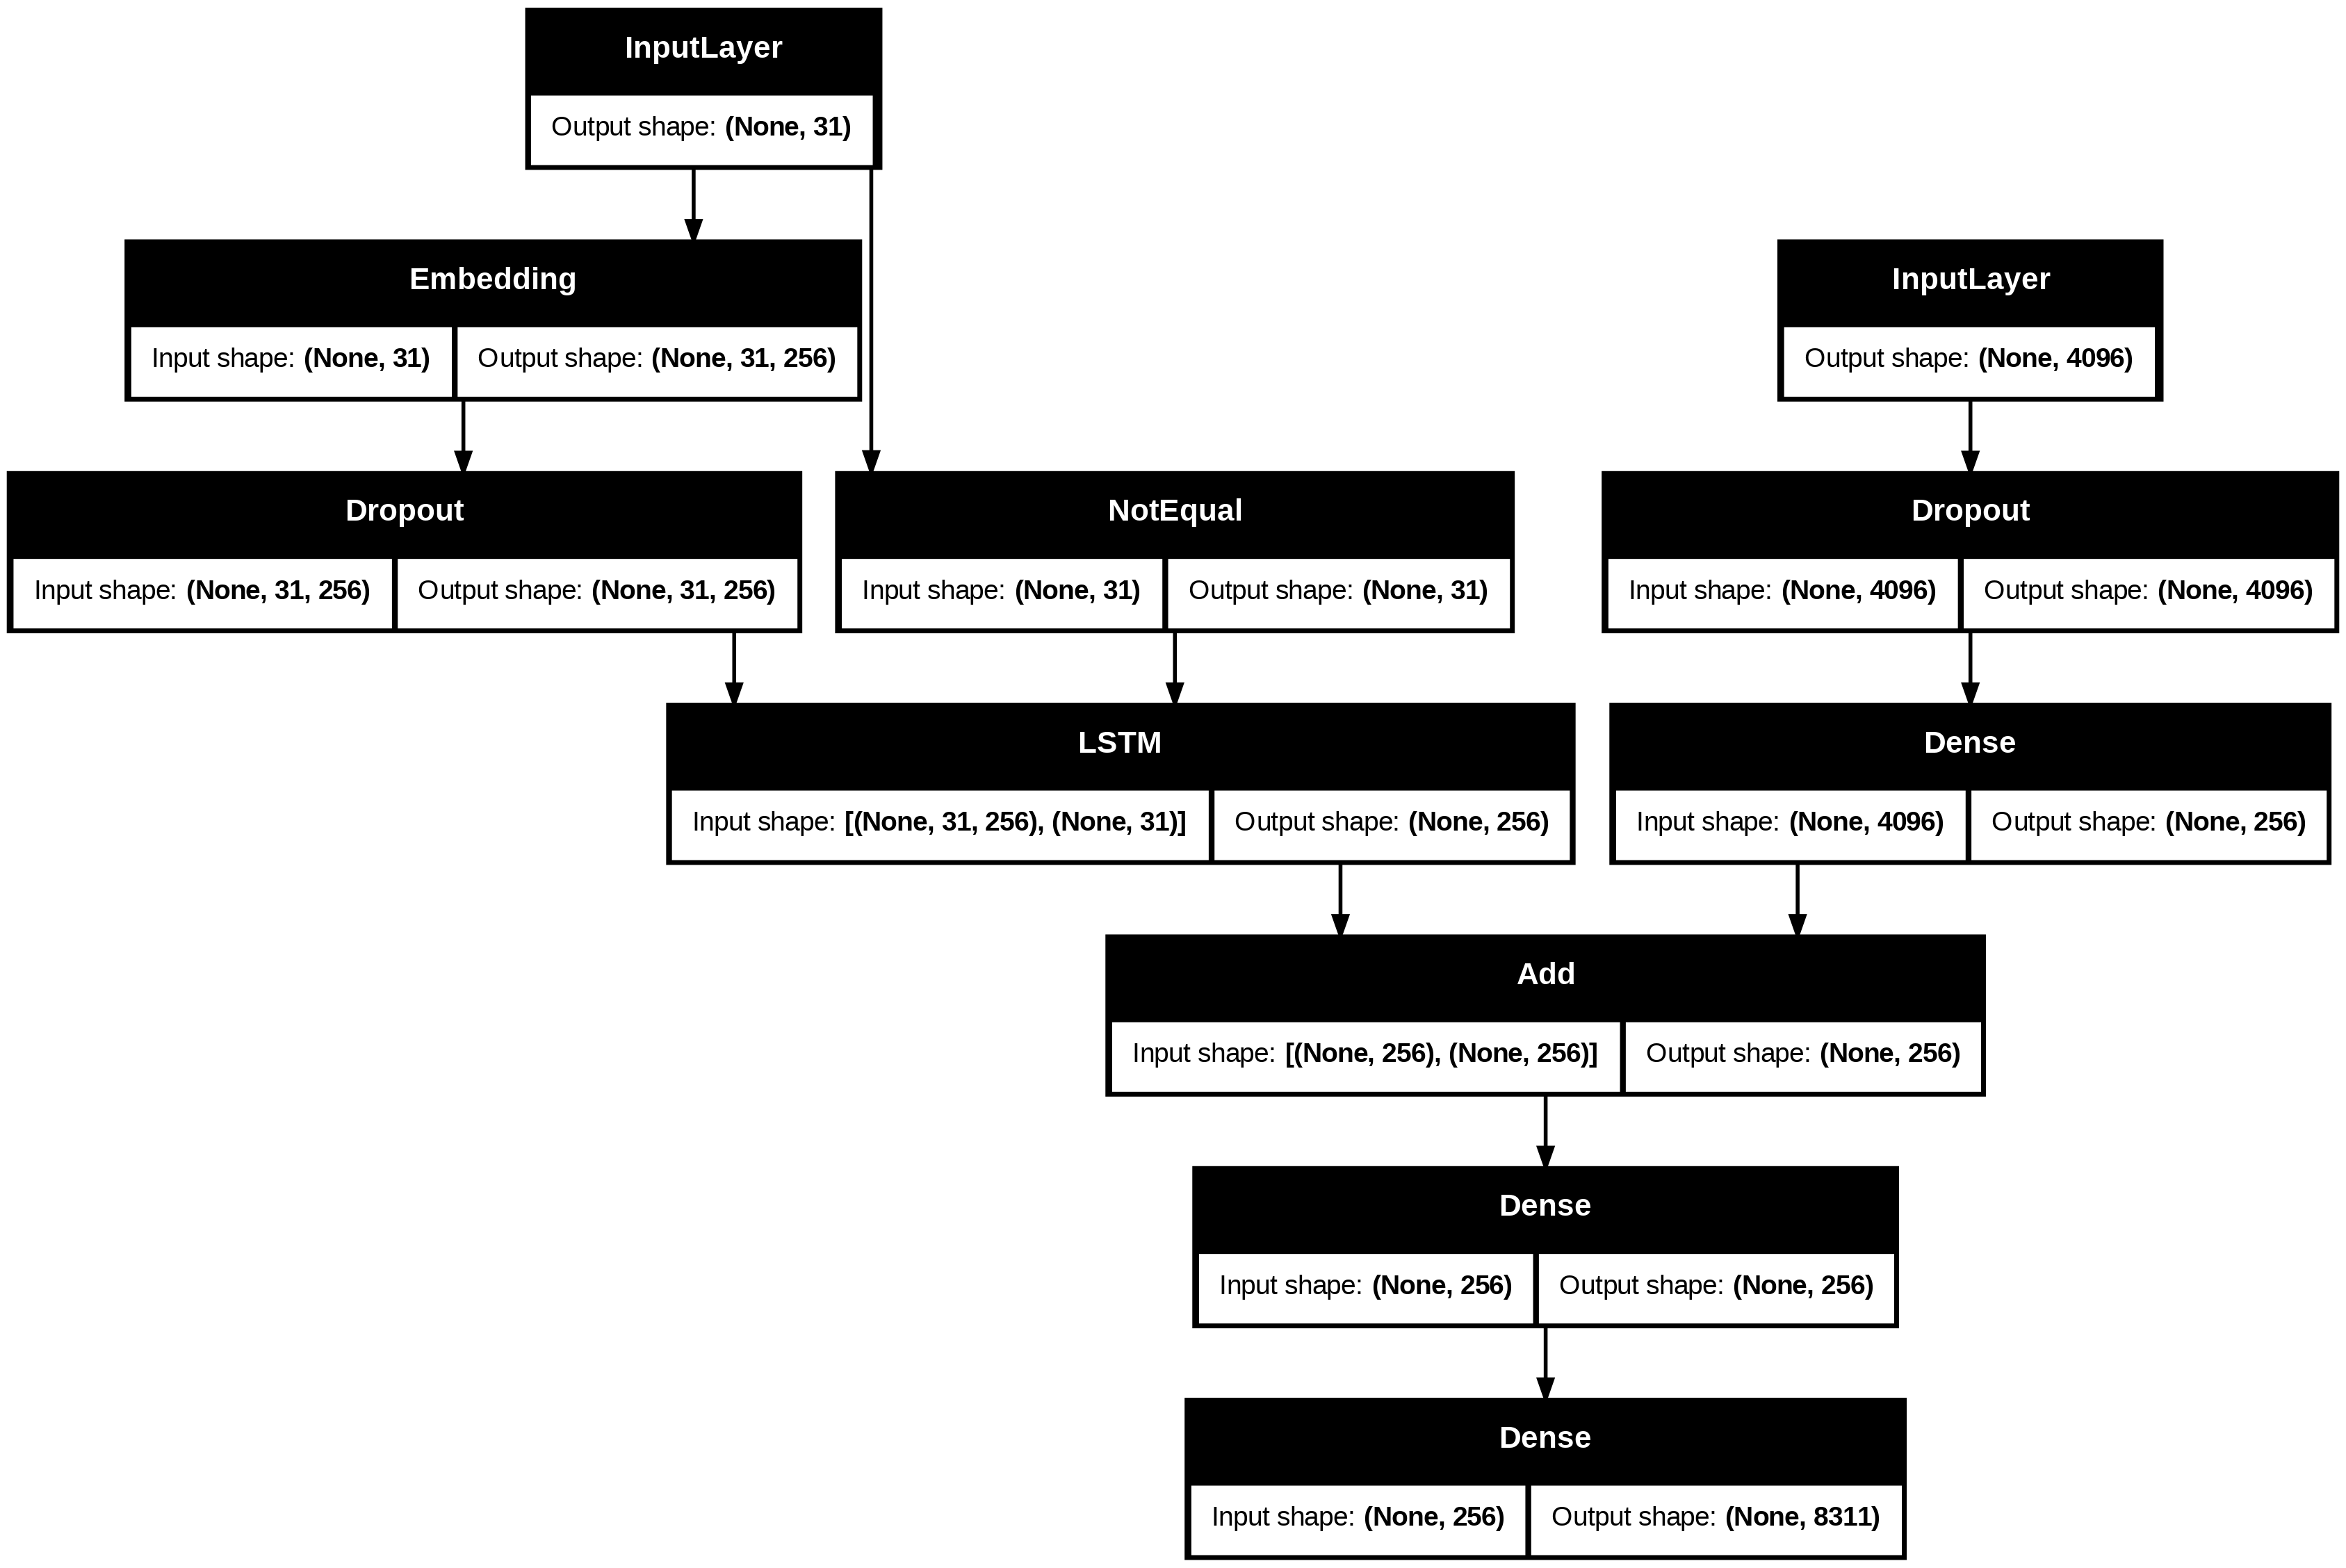

In [67]:
# # modelcreation

# # encoder model
# # img feature layers
# inputs1 = Input(shape=(4096,))
# fe1 = Dropout(0.4)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)

# # seq fature layers
# inputs2 = Input(shape=(max_length,))
# seq1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# seq2 = Dropout(0.4)(seq1)
# seq3 = LSTM(256, return_sequences=False, recurrent_activation='sigmoid', activation='tanh', unroll=True)(seq2)




# # decoder model
# decoder1 = add([fe2, seq3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

# # plot the model
# plot_model(model, show_shapes=True)

In [51]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.optimizers import Adam
import keras_tuner as kt

def build_model(hp):
    lstm_units = hp.Int('lstm_units', 128, 512, step=64)
    embed_dim = hp.Int('embed_dim', 128, 512, step=64)

    # Image feature extractor
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(hp.Float('dropout_img', 0.3, 0.5, step=0.1))(inputs1)
    fe2 = Dense(lstm_units, activation='relu')(fe1)  

    inputs2 = Input(shape=(max_length,))
    seq1 = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)(inputs2)
    seq2 = Dropout(hp.Float('dropout_seq', 0.3, 0.5, step=0.1))(seq1)
    seq3 = LSTM(lstm_units, return_sequences=False, activation='tanh',
                recurrent_activation='sigmoid', unroll=True)(seq2)

    decoder1 = add([fe2, seq3])  
    decoder2 = Dense(hp.Int('dense_dec', 128, 512, step=64), activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
    )

    return model


In [52]:
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  
    executions_per_trial=1,
    directory='tuner_results',
    project_name='caption_tune'
)


Reloading Tuner from tuner_results/caption_tune/tuner0.json


In [53]:
batch_size=100
from sklearn.model_selection import train_test_split

train_ids, val_ids = train_test_split(train, test_size=0.2, random_state=42)

train_gen = datagenerator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_gen = datagenerator(val_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

steps_train = len(train_ids) // batch_size
steps_val = len(val_ids) // batch_size


In [54]:
tuner.search(
    train_gen,
    epochs=10,
    steps_per_epoch=steps_train,
    validation_data=val_gen,
    validation_steps=steps_val,
    verbose=1
)


Trial 3 Complete [00h 46m 25s]
val_loss: 5.356225967407227

Best val_loss So Far: 5.356225967407227
Total elapsed time: 01h 08m 27s


In [55]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Best Hyperparameters:
dropout_img: 0.4
dense_img: 128
embed_dim: 320
dropout_seq: 0.3
lstm_units: 192
dense_dec: 448
learning_rate: 0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Recreate generator using full train list
full_train_gen = datagenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
steps = len(train) // batch_size

# Continue training the best model for more epochs
best_model.fit(full_train_gen, epochs=2, steps_per_epoch=steps, verbose=1)


Epoch 1/2


In [ ]:
best_model.save("best_caption_model.h5")


In [ ]:
from keras.models import load_model
model = load_model("best_caption_model.h5")


In [1]:
# ✅ FILTER: Keep only image-caption mappings where features exist
mapping = {k: v for k, v in mapping.items() if k in features}

# ✅ FILTER: Update train list accordingly
train = [img_id for img_id in train if img_id in features]

# train the model
epochs = 10
batch_size = 100
steps = len(train) // batch_size

for i in range(epochs):
  # create data generator
  generator = datagenerator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # fit for i epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

NameError: name 'mapping' is not defined

In [68]:
# save the model
model.save('model_custom.keras')

input/  lib/  model_custom.keras  model.png  working/


In [69]:
# Generate Captions for the image
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [70]:
# generate captions for the image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = '<start>'
    # iterate over max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == '<end>':
            break
    return in_text

In [71]:
from nltk.translate.bleu_score import corpus_bleu

In [72]:
# validate with text data
actual, predict = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  # split into words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  # append to the list
  actual.append(actual_captions)
  predict.append(y_pred)

# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predict, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predict, weights=(0.5, 0.5, 0, 0)))



  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.137693
BLEU-2: 0.064811


In [73]:
# visualize the results
from PIL import Image
import matplotlib.pyplot as plt

In [100]:
def generate_captions(image_name):
    # load the img
    image_id = image_name.split('.')[0]
    img_path = os.path.join(extract_folders, 'Images', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('Actual')
    for caption in captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('\nPredicted')
    print(y_pred.split('end')[0].strip(), '<end>')
    plt.imshow(image)

Actual
<start> boy is standing on snowy hill looking at sunset or sunrise <end>
<start> child stands in the snow <end>
<start> child stands in the snow and looks at pretty sky <end>
<start> "boy in winter gear facing away in snowy area <end>
<start> someone with red had and red and white mittens standing in the snow overlooking lake <end>

Predicted
<start> two dogs are playing in the water <end>


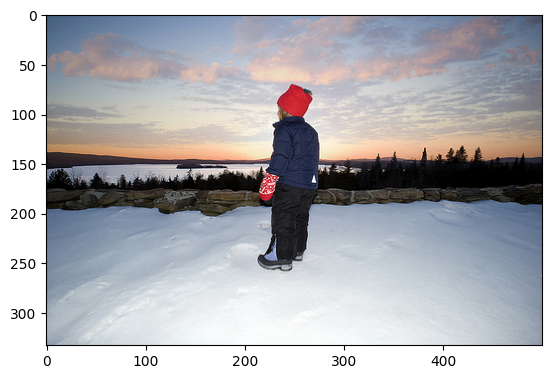

In [113]:
generate_captions('3380407617_07b53cbcce.jpg')